In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
from itertools import product
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import re
import time

from my_modules.plot_and_stat_funcs import *
from my_modules.transformations import *

In [2]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv').target
X_val = pd.read_csv('data/X_val.csv')
y_val = pd.read_csv('data/y_val.csv').target

In [3]:
X_train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,...,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",Encoded_Customers,Encoded_sum_target
0,1,6,0,0,0,893,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,1,5,0,0,0,892,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,1,4,0,0,0,891,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,1,3,0,0,0,890,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,1,2,0,0,0,889,127,29,5,0,...,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


As light GBM allows only alphanumeric characters and underscores in column names remove other characters.

In [4]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
X_train, y_train = X_train[y_train != 0], y_train[y_train != 0]
X_val, y_val = X_val[y_val != 0], y_val[y_val != 0]

In [6]:
def RMSPE(y_true, y_pred):
    y_t, y_p = np.array(y_true), np.array(y_pred)
    y_t, y_p = y_t[y_t != 0], y_p[y_t != 0]
    return np.sqrt(np.mean(
        ((y_true - y_pred) / y_true)**2
    ))

In [7]:
def all_info_about_model(model_init, X_train, y_train, X_val, y_val, metric, param_grid, include_train=True, show_loop_params=True, *fit_args, **fit_kwargs):
    param_names = list(param_grid.keys())
    param_values = list(product(*list(param_grid.values())))
    scores_df = pd.DataFrame(param_values, columns=param_names)
    if include_train:
        train_scores = []
    val_scores = []
    eval_time = []
    for i, param_value in enumerate(param_values):
        start = time.time()
        params = dict(zip(param_names, param_value))
        if show_loop_params:
            print('\n', params, '\n')
        model = model_init(**params)
        model.fit(X_train, y_train, *fit_args, **fit_kwargs)
        if include_train:
            train_scores.append(metric(y_train, model.predict(X_train)))
        val_scores.append(metric(y_val, model.predict(X_val)))
        eval_time.append(time.time() - start)
    
    if include_train:
        scores_df.loc[:, 'train_metric'] = train_scores
    scores_df.loc[:, 'val_metric'] = val_scores
    scores_df.loc[:, 'eval_time (sec)'] = eval_time
    
    return scores_df

In [15]:
def plot_eval_results(x, data,):
    plt.figure(figsize=(12, 7))
    plt.plot(data[x], data['train_metric'])
    plt.plot(data[x], data['val_metric'])
    plt.legend(['train_rmspe', 'val_rmspe'])
    plt.xlabel(x)
    plt.ylabel('rmspe')
    plt.title(f'rmspe on train and validation datasets depending on {x}')
    plt.xticks(ticks=data[x], labels=data[x])
    plt.show()

# LGBM

## Origin target

restart this and change params to tune

In [ ]:
max_depth_results = all_info_about_model(partial(LGBMRegressor, num_leaves=1000, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1] + list(range(1, 20)),
                     },
                                         show_loop_params=True,
)
max_depth_results.to_csv('data/results/max_depth_results.csv', index=False)

In [8]:
max_depth_results = pd.read_csv('data/results/max_depth_results.csv')

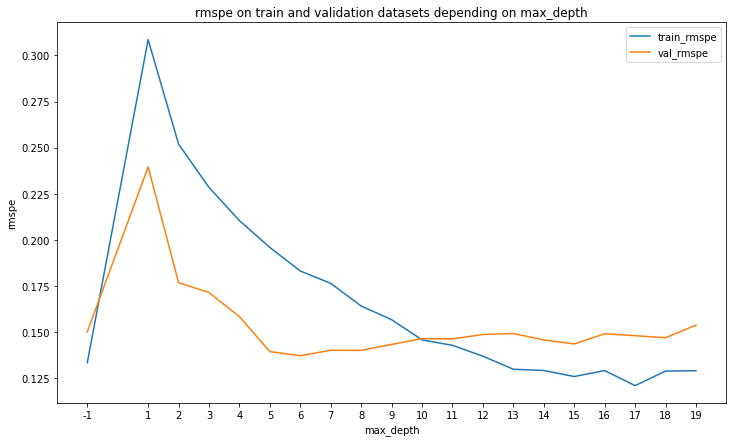

In [16]:
plot_eval_results('max_depth', max_depth_results)

The least val rmspe is for max_depth in \[5, 6, 7\].

In [ ]:
num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205,),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'num_leaves': list(range(10, 121, 10)),
                     },
                                         show_loop_params=True,
)
num_leaves_results.to_csv('data/results/num_leaves_results.csv', index=False)

In [12]:
num_leaves_results = pd.read_csv('data/results/num_leaves_results.csv')

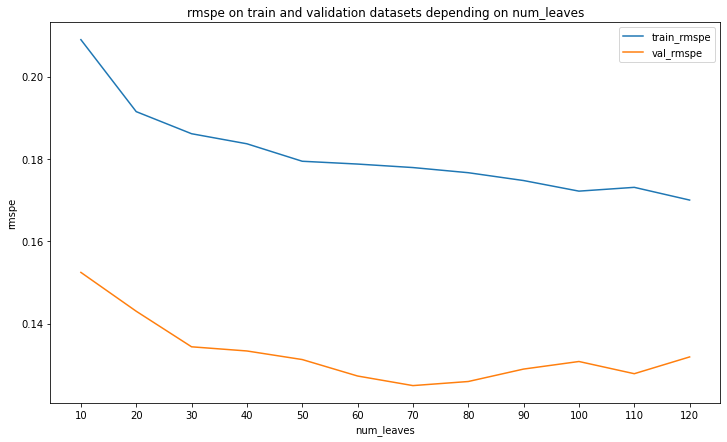

In [17]:
plot_eval_results('num_leaves', num_leaves_results)

In [ ]:
max_depth_num_leaves_results = all_info_about_model(partial(LGBMRegressor, n_estimators=1000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'max_depth': [-1, 5, 6, 7],
                         'num_leaves': [60, 70, 80],
                     },
                                         show_loop_params=True,
)
max_depth_num_leaves_results.to_csv('data/results/max_depth_num_leaves_results.csv', index=False)

In [20]:
max_depth_num_leaves_results = pd.read_csv('data/results/max_depth_num_leaves_results.csv')

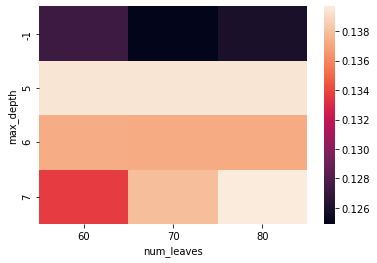

In [21]:
sns.heatmap(max_depth_num_leaves_results.set_index(['max_depth', 'num_leaves']).unstack()['val_metric'])
plt.show()

So the parameters that minimize rmspe are max_depth=-1 and num_leaves=70

Let's see how the error depends on learning_rate parameter.

In [ ]:
total_results = all_info_about_model(partial(LGBMRegressor, max_depth=-1, num_leaves=70, n_estimators=5000, random_state=205, ),
                     X_train, y_train, X_val, y_val, RMSPE,
                     {
                         'learning_rate': np.linspace(0.05, 0.15, 11),
                     },
                                     eval_set=[(X_val, y_val)],
         eval_metric=lambda y_true, y_pred: ('RMSPE', RMSPE(y_true, y_pred), False),
                                     early_stopping_rounds=150,
                                     verbose=100,
                                         show_loop_params=True,
)

In [22]:
total_results = pd.read_csv('data/results/total_results.csv')

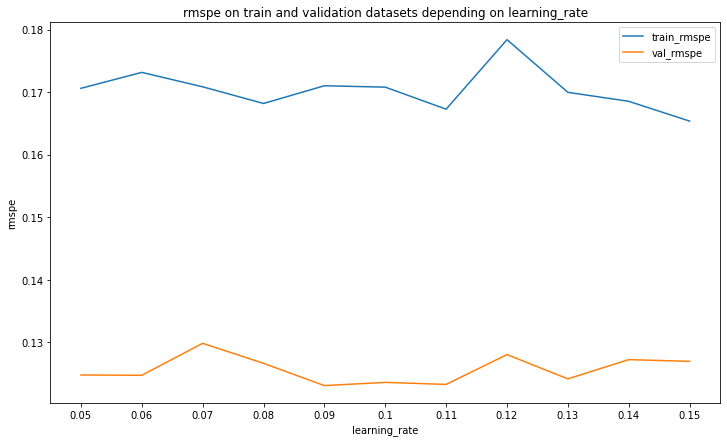

In [23]:
plot_eval_results('learning_rate', total_results)

Let's see the row with minimum rmspe.

In [26]:
total_results.loc[[total_results.val_metric.argmin()]]

,learning_rate,train_metric,val_metric,eval_time (sec)
4,0.09,0.171015,0.123062,189.95584


The best params are max_depth=-1, num_leaves=70, learning_rate=0.09

## Transformed target

Boks-Koks transforming  
$
z = \begin{cases}
\frac{(y+a)^\lambda - 1}{\lambda}, \lambda \ne 0\\
ln(y+a), \lambda=0
\end{cases}
$

In [ ]:
def box_cox(y, mu, shift=0.0):
    if mu == 0.0:
        return np.log(y + shift)
    return ((y + shift)**mu - 1) / mu

def inv_box_cox(z, mu, shift=0.0):
    if mu == 0.0:
        return np.e**z - shift
    return (1 + z * mu)**(1 / mu) - shift

def box_cox_RMSPE(y_true, y_pred, mu, shift):
    return RMSPE(inv_box_cox(y_true, mu, shift), inv_box_cox(y_pred, mu, shift))

In [ ]:
lgbm_boxcox = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.09, n_estimators=5000, random_state=205)
lgbm_boxcox.fit(X_train, y_train_boxcox,
                                     eval_set=[(X_val, y_val_boxcox)],
                         eval_metric=lambda y_true, y_pred: ('RMSPE', RMSPE(inv_boxcox(y_true, lmbda), inv_boxcox(y_pred, lmbda)), False),
                                     early_stopping_rounds=150,
                                     verbose=100,
)

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's l2: 0.00752589	valid_0's RMSPE: 0.261396
[200]	valid_0's l2: 0.00705103	valid_0's RMSPE: 0.249926
[300]	valid_0's l2: 0.00671317	valid_0's RMSPE: 0.242144
[400]	valid_0's l2: 0.00657628	valid_0's RMSPE: 0.239089
[500]	valid_0's l2: 0.00648056	valid_0's RMSPE: 0.23692
[600]	valid_0's l2: 0.00639249	valid_0's RMSPE: 0.234849
[700]	valid_0's l2: 0.00633729	valid_0's RMSPE: 0.23346
[800]	valid_0's l2: 0.00628428	valid_0's RMSPE: 0.232236
[900]	valid_0's l2: 0.00625667	valid_0's RMSPE: 0.231586
[1000]	valid_0's l2: 0.00623837	valid_0's RMSPE: 0.231187
[1100]	valid_0's l2: 0.00622878	valid_0's RMSPE: 0.23095
[1200]	valid_0's l2: 0.00623008	valid_0's RMSPE: 0.230939
[1300]	valid_0's l2: 0.00620784	valid_0's RMSPE: 0.230428
[1400]	valid_0's l2: 0.00620061	valid_0's RMSPE: 0.230249
[1500]	valid_0's l2: 0.00620446	valid_0's RMSPE: 0.230318
Early stopping, best iteration is:
[1423]	valid_0's l2: 0.00619693	valid_0's RM

LGBMRegressor(learning_rate=0.09, n_estimators=5000, num_leaves=70,
              random_state=205)

In [ ]:
boxcox_scores = []
mus = np.linspace(-1, 1, 41)
for mu in mus:
    
    shift = 1
    y_train_boxcox = box_cox(y_train, mu, shift)
    y_val_boxcox = box_cox(y_val, mu, shift)
    
    lgbm_boxcox = LGBMRegressor(num_leaves=70, max_depth=-1, learning_rate=0.09, n_estimators=5000, random_state=205)
    lgbm_boxcox.fit(X_train, y_train_boxcox,
                                        eval_set=[(X_val, y_val_boxcox)],
                            eval_metric=lambda y_true, y_pred: ('RMSPE', box_cox_RMSPE(y_true, y_pred, mu, shift), False),
                                        early_stopping_rounds=150,
                                        verbose=100,
    )
    boxcox_scores.append(box_cox_RMSPE(y_val_boxcox, lgbm_boxcox.predict(X_val), mu, shift))

Training until validation scores don't improve for 150 rounds.
[100]	valid_0's l2: 9.55686e-10	valid_0's RMSPE: 0.159354
[200]	valid_0's l2: 8.53389e-10	valid_0's RMSPE: 0.151291
[300]	valid_0's l2: 7.88489e-10	valid_0's RMSPE: 0.14664
[400]	valid_0's l2: 7.4936e-10	valid_0's RMSPE: 0.143479
[500]	valid_0's l2: 7.24952e-10	valid_0's RMSPE: 0.141256
[600]	valid_0's l2: 7.09081e-10	valid_0's RMSPE: 0.139665
[700]	valid_0's l2: 6.93434e-10	valid_0's RMSPE: 0.138166
[800]	valid_0's l2: 6.83753e-10	valid_0's RMSPE: 0.137211
[900]	valid_0's l2: 6.7698e-10	valid_0's RMSPE: 0.136345
[1000]	valid_0's l2: 6.68417e-10	valid_0's RMSPE: 0.135259
[1100]	valid_0's l2: 6.59817e-10	valid_0's RMSPE: 0.134197
[1200]	valid_0's l2: 6.57772e-10	valid_0's RMSPE: 0.133985
[1300]	valid_0's l2: 6.52027e-10	valid_0's RMSPE: 0.133383
[1400]	valid_0's l2: 6.48539e-10	valid_0's RMSPE: 0.132946
[1500]	valid_0's l2: 6.46756e-10	valid_0's RMSPE: 0.132781
[1600]	valid_0's l2: 6.49782e-10	valid_0's RMSPE: 0.133176
Early

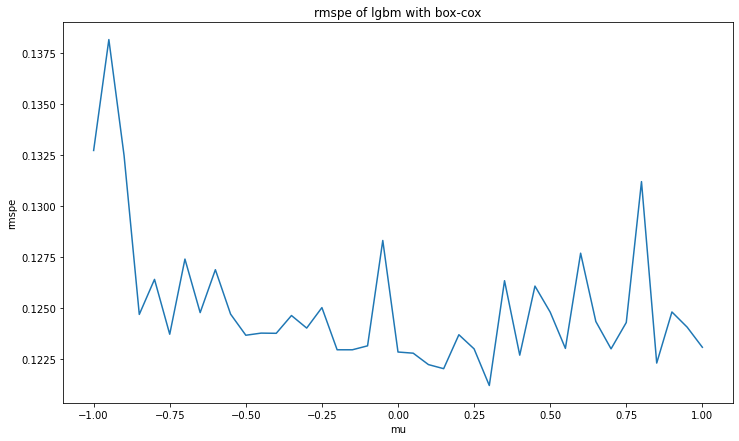

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(mus, boxcox_scores)
plt.xlabel('mu')
plt.ylabel('rmspe')
plt.title('rmspe of lgbm with box-cox')
plt.show()

In [ ]:
print('The minimum rmspe:', min(boxcox_scores))
print('The mu parameter:', mus[np.argmin(boxcox_scores)])

The minimum rmspe: 0.1211832864962335
The mu parameter: 0.30000000000000004


In [ ]:
mu = 0.3
shift = 1
y_train_boxcox = box_cox(y_train, mu, shift)
y_val_boxcox = box_cox(y_val, mu, shift)

# Linear Regression

In [ ]:
X_train.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,1,6,0,0,0,893,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,1,5,0,0,0,892,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,1,4,0,0,0,891,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,1,3,0,0,0,890,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,1,2,0,0,0,889,127,29,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [ ]:
cols_to_normalize = ['DayOfWeek', 'ordered_day', 'ordered_week', 'ordered_month']
scaler = MinMaxScaler()

X_train_norm = X_train.copy()
X_train_norm.loc[:, cols_to_normalize] = scaler.fit_transform(X_train_norm[cols_to_normalize])

X_val_norm = X_val.copy()
X_val_norm.loc[:, cols_to_normalize] = scaler.transform(X_val_norm[cols_to_normalize])

In [ ]:
X_train_norm.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,ordered_day,ordered_week,ordered_month,MonthOfYear,Promo2,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,EncodedDistance,EncodedCompetitionMonthsFromStart,EncodedPromo2WeeksFromStart,PromoInterval_,PromoInterval_JanAprJulOct,PromoInterval_FebMayAugNov,PromoInterval_MarJunSeptDec,Encoded_Customers,Encoded_sum_target
0,1,0.833333,0,0,0,1.000000,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
1,1,0.666667,0,0,0,0.998880,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
2,1,0.500000,0,0,0,0.997760,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
3,1,0.333333,0,0,0,0.996641,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261
4,1,0.166667,0,0,0,0.995521,1.0,1.0,5,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.321681,0.940159,0.0,1.0,0.0,0.0,0.0,-0.362074,-0.900261


In [ ]:
X_train_norm_nonzero = X_train_norm[y_train != 0]
y_train_norm_nonzero = y_train[y_train != 0]

X_val_norm_nonzero = X_val_norm[y_val != 0]
y_val_norm_nonzero = y_val[y_val != 0]

In [ ]:
lin_reg = ElasticNet()
lin_reg.fit(X_train_norm_nonzero, y_train_norm_nonzero, sample_weight=1/y_train_norm_nonzero**2)
lin_reg_predicted = lin_reg.predict(X_val_norm_nonzero)

In [ ]:
RMSPE(y_val_norm_nonzero, lin_reg_predicted)

0.28976072656230173

# kNN

In [ ]:
knn_scores = []
knn_n_neighbors = range(2, 21, 2)
for n_neighbors in knn_n_neighbors:
    print('n_neighbors:', n_neighbors, '\n')
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X_train_norm, y_train)
    knn_predicted = knn.predict(X_val_norm)
    knn_scores.append(RMSPE(y_val, knn_predicted))

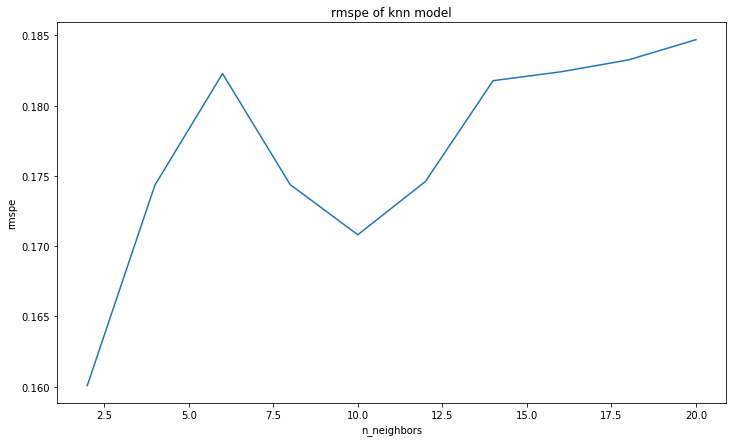

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(knn_n_neighbors, knn_scores)
plt.xlabel('n_neighbors')
plt.ylabel('rmspe')
plt.title('rmspe of knn model')
plt.show()